### This notebook is for building dendrogram trees for a given neuroimaging dataset which includes Structural Connectivity (SC) and Functional Connectivity (FC) matrices. The dendrogram trees are built using the weighted method and the correlation distance metric. 

In [1]:
from src.tree_functions import *
from src.connectivity_functions import *
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

First, it's needed to define the connectome size, it's possible to choose between the following number of nodes: 183, 391, 568, 729, 964, 1242, 1584, 1795, 2165

In [3]:
project_path = "/workspaces/bha2"
CONN_SIZE = 183

The trees are built using the population average of the SC and FC matrices. In order to not reload the individual matrices or recalculate the population average, the code checks if the population average matrices are already in the `bha2/tmp` folder. If they are not, the code will load the individual matrices and calculate the population average matrices.

In [5]:
# check if fcm and scm are stored in tmp folder
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(CONN_SIZE), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(CONN_SIZE), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    os.mkdir(os.path.join(project_path, "tmp"))
    np.save(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


Preprocessing of the SC and FC population matrices is needed before building the dendrogram trees. The preprocessing includes the following steps:
* Remove ROIs disconnected in the SC matrix
* Calculate the density of the SC matrix and apply a threshold to the FC matrix to keep the same density in both matrices
* Remove ROIs disconnected in the thresholded SC matrix
* Binarize both matrices


In [6]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.59249305742184


As some ROIs has been removed from the analyses, it's necessary to modify the initial parcellation to remove the same ROIs. The initial parcellation without the removed ROIs is saved in the `bha2/data/processed/CONN_SIZE` folder.

In [7]:
#Loading the original parcellation
parcellation_name = "craddock_" + str(CONN_SIZE) + ".nii.gz"
parcellation = nib.load(os.path.join(project_path, "brain_templates", parcellation_name))
parcellation_vol = parcellation.get_fdata()

#Empty matrix to store the parcellation without the rows removed
parcellation_nonzero = np.zeros(
    (parcellation_vol.shape[0], parcellation_vol.shape[1], parcellation_vol.shape[2])
)

#Removing the not connected ROIs in the original parcellation
old_rois = np.arange(1, parcellation_vol.max() + 1, dtype=int)
old_rois = np.delete(old_rois, zero_rows_sc)
old_rois = np.delete(old_rois, zero_rows_fc)

#Assigning the new ROI numbers to the parcellation
for idx, rois in enumerate(old_rois):
    parcellation_nonzero[parcellation_vol == rois] = idx + 1

parcellation_nonzero_img = nib.Nifti1Image(parcellation_nonzero, affine=parcellation.affine)

if not(os.path.exists(os.path.join(project_path, "data", "processed", "n" + str(CONN_SIZE)))):
    os.mkdir(os.path.join(project_path, "data", "processed", "n" + str(CONN_SIZE)))

nib.save(parcellation_nonzero_img, os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(CONN_SIZE),
        "initial_parcellation.nii.gz",
    ))

Text(0.5, 1.0, 'SC matrix')

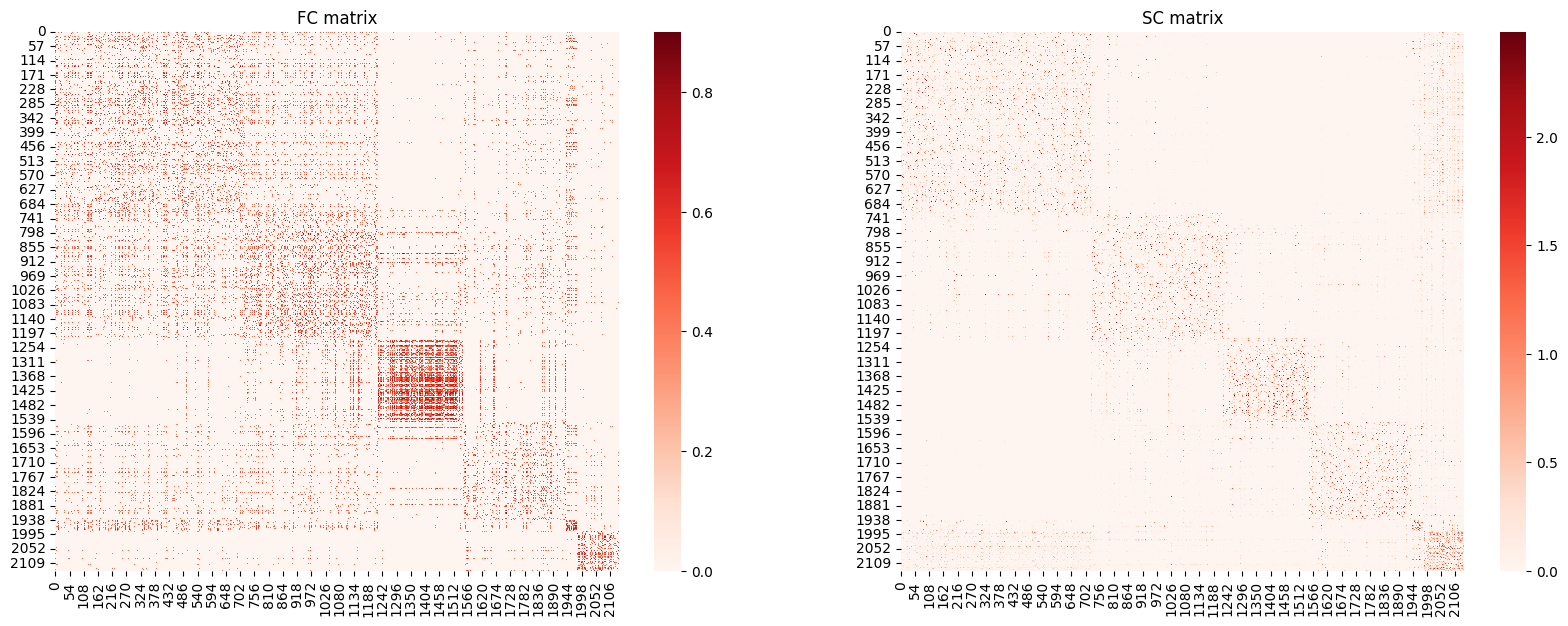

In [69]:
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(fcm_nonzero, ax=ax[0], cmap="Reds")
ax[0].set_title("FC matrix")
sns.heatmap(np.log10(scm_nonzero+1), ax=ax[1], cmap="Reds")
ax[1].set_title("SC matrix")

The binary SC and FC matrices are fusioned using a $\gamma$ parameter, in this work, eleven different $\gamma$ values are used. It's necessary to define the lower level of the tree and the upper level (in this case, the full tree is represented). The dendrogram trees are stored as .json dictionaries in the bha2/data/processed folder.

In [ ]:
tree_folder = "tree_network_measures"
tree_lower = 2
tree_upper = fcm_bin.shape[0]
# get the rows with all the elements with zero

for g in np.arange(0, 1.1, 0.1):
    W = matrix_fusion(g, fcm_bin, scm_bin)
    t_dict = tree_dictionary(tree_lower, tree_upper, W, tree_class="full")
    json.dump(
        t_dict,
        open(
            os.path.join(
                project_path,
                "data",
                "processed",
                "n" + str(CONN_SIZE),
                "tree_g_full_" + str(round(g, 2)) + ".json",
            ),
            "w",
        ),
    )